# import

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, concatenate
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans


In [1]:
import pandas as pd
import ast
from sklearn.metrics import classification_report


In [2]:
from gensim.models import Word2Vec


In [3]:
df1 = pd.read_csv('./data/userList (10001~20001).csv')
df2 = pd.read_csv('./data/userList(20001~30000).csv')
df3 = pd.read_csv('./data/userList(30000~40001).csv')
df4 = pd.read_csv('./data/userList(40001~50001).csv')
df5 = pd.read_csv('./data/userList.csv')

dfs = [df1, df2, df3, df4]
combined_df = pd.concat(dfs)

combined_df.reset_index(drop=True, inplace=True)
df5.columns = combined_df.columns
df5.dropna(inplace=True)
combined_df = pd.concat([combined_df, df5])
combined_df.reset_index(drop=True, inplace=True)

col = 'rank	rightCnt	wrongCnt	time out	memory exceed	print exceed	runTime error	compile error	solvedProblemList	triedNotsolvedList'
col = col.split('\t')

def check_no_list(c, df):
    temp = df[df[c] == '[]']
    return temp


is_null = pd.DataFrame()

for i in range(len(col)):
    temp = check_no_list(col[i], combined_df)
    is_null = pd.concat([temp, is_null])


drop_indices = is_null.index

combined_df_dropped = combined_df.drop(drop_indices)

df = combined_df_dropped.reset_index(drop=True)

tier_0 = df[df['tier'] == 0].index
df.drop(tier_0, inplace=True)

def string_to_list(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        return [] 


li='rank	rightCnt	wrongCnt	time out	memory exceed	print exceed	runTime error	compile error'
col = li.split('\t')

def turn_num(s):
    cs = s.apply(string_to_list).explode()
    return cs

for i in range(len(col)):
    df[col[i]] = turn_num(df[col[i]])

for column in col:
    df[column] = pd.to_numeric(df[column], errors='coerce')


df[col] = df[col].apply(lambda x: x.fillna(0).astype(int))

df.reset_index(drop=True, inplace=True)
df['tier'] = df['tier'].astype(int)

df['solvedProblemList'] = df['solvedProblemList'].apply(ast.literal_eval)
df['triedNotsolvedList'] = df['triedNotsolvedList'].apply(ast.literal_eval)



In [4]:
df

,id,tier,rank,rightCnt,wrongCnt,time out,memory exceed,print exceed,runTime error,compile error,solvedProblemList,triedNotsolvedList
0,jh5154,15,10033,546,252,76,2,7,42,33,"[1000, 1001, 1003, 1008, 1012, 1018, 1021, 102...","[1722, 1725, 1916, 11279, 12902, 13199, 13398]"
1,baefr,15,10034,515,235,100,34,5,53,26,"[1000, 1001, 1002, 1008, 1010, 1011, 1012, 101...","[1062, 2343, 2615, 2931, 2954, 3025, 6588, 698..."
2,nacean,15,10035,423,339,107,20,6,36,40,"[1000, 1001, 1003, 1008, 1009, 1010, 1012, 101...","[1038, 1039, 1937, 1981, 2407, 2533, 6087, 993..."
3,klxex,15,10036,451,271,88,35,4,83,45,"[1003, 1005, 1010, 1012, 1018, 1021, 1038, 104...","[1253, 1509, 1774, 2133, 2473, 7662, 14002]"
4,qortndud97,15,10037,570,250,57,32,14,35,38,"[1000, 1001, 1005, 1008, 1009, 1010, 1012, 103...","[1153, 1701, 1777, 1799, 1865, 2076, 2243, 260..."
...,...,...,...,...,...,...,...,...,...,...,...,...
84017,kjsmel,5,100269,58,1,116,0,22,7,3,"[1000, 1001, 1008, 1065, 1110, 1152, 1157, 119...",[1011]
84018,limy0213,5,100269,58,1,0,0,0,9,16,"[1000, 1001, 1008, 1026, 1094, 1100, 1476, 192...",[10172]
84019,palzmnbvcx,5,100269,58,4,116,60,0,6,2,"[1000, 1001, 1008, 1110, 1330, 1427, 1436, 154...","[1181, 1929, 10814, 10989]"
84020,planet4869,6,100269,58,4,116,0,0,9,1,"[1000, 1001, 1010, 1094, 1149, 1152, 1157, 120...","[1008, 1475, 1929, 2805]"


In [5]:
tier_0 = df[df['tier'] == 0].index
df.drop(tier_0, inplace=True)

In [6]:
df.to_csv('./clean_df.csv')

In [9]:
df.drop('id', axis=1, inplace=True)

# 전처리

<Axes: xlabel='tier'>

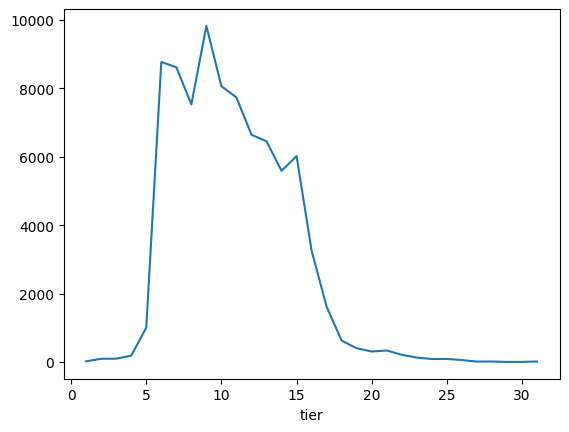

In [22]:
df.tier.value_counts().sort_index().plot()

In [24]:
tier_counts = df.tier.value_counts()

In [25]:

def combine_tiers(tier_counts, target_tier_count):
    combined_counts = tier_counts.copy()
    while len(combined_counts) > target_tier_count:
        min_combined_count = float('inf')
        tiers_to_combine = None
        for i in range(len(combined_counts) - 1):
            combined_count = combined_counts.iloc[i] + combined_counts.iloc[i + 1]
            if combined_count < min_combined_count:
                min_combined_count = combined_count
                tiers_to_combine = (combined_counts.index[i], combined_counts.index[i + 1])

        combined_counts[tiers_to_combine[0]] += combined_counts[tiers_to_combine[1]]
        combined_counts.drop(tiers_to_combine[1], inplace=True)

    return combined_counts

target_tier_count = 15
new_tier_counts = combine_tiers(tier_counts, target_tier_count)
new_tier_counts.sort_index(inplace=True)
new_tier_counts


tier
4      841
5     1634
6     8767
7     8615
8     7528
9     9822
10    8060
11    7733
12    6643
13    6451
14    5589
15    6018
16    3258
17    1617
19    1265
Name: count, dtype: int64

In [26]:


def create_tier_mapping(tier_counts, combined_counts):
    tier_mapping = {}
    combined_tiers = combined_counts.index.tolist()

    combined_index = 0
    for tier in tier_counts.index:
        if tier in combined_tiers:
            combined_index = combined_tiers.index(tier)
        tier_mapping[tier] = combined_tiers[combined_index]

    return tier_mapping

tier_mapping = create_tier_mapping(tier_counts, new_tier_counts)

df['new_tier'] = df['tier'].map(tier_mapping)

df.head()


,tier,rank,rightCnt,wrongCnt,time out,memory exceed,print exceed,runTime error,compile error,solvedProblemList,triedNotsolvedList,new_tier
0,15,10033,546,252,76,2,7,42,33,"[1000, 1001, 1003, 1008, 1012, 1018, 1021, 102...","[1722, 1725, 1916, 11279, 12902, 13199, 13398]",15
1,15,10034,515,235,100,34,5,53,26,"[1000, 1001, 1002, 1008, 1010, 1011, 1012, 101...","[1062, 2343, 2615, 2931, 2954, 3025, 6588, 698...",15
2,15,10035,423,339,107,20,6,36,40,"[1000, 1001, 1003, 1008, 1009, 1010, 1012, 101...","[1038, 1039, 1937, 1981, 2407, 2533, 6087, 993...",15
3,15,10036,451,271,88,35,4,83,45,"[1003, 1005, 1010, 1012, 1018, 1021, 1038, 104...","[1253, 1509, 1774, 2133, 2473, 7662, 14002]",15
4,15,10037,570,250,57,32,14,35,38,"[1000, 1001, 1005, 1008, 1009, 1010, 1012, 103...","[1153, 1701, 1777, 1799, 1865, 2076, 2243, 260...",15


In [35]:


def list_to_text(lst):
    return ' '.join(map(str, lst))

df['solvedProblemList_text'] = df['solvedProblemList'].apply(list_to_text)



In [37]:
df

,tier,rank,rightCnt,wrongCnt,time out,memory exceed,print exceed,runTime error,compile error,solvedProblemList,triedNotsolvedList,new_tier,solvedProblemList_text
0,15,10033,546,252,76,2,7,42,33,"[1000, 1001, 1003, 1008, 1012, 1018, 1021, 102...","[1722, 1725, 1916, 11279, 12902, 13199, 13398]",15,1000 1001 1003 1008 1012 1018 1021 1026 1062 1...
1,15,10034,515,235,100,34,5,53,26,"[1000, 1001, 1002, 1008, 1010, 1011, 1012, 101...","[1062, 2343, 2615, 2931, 2954, 3025, 6588, 698...",15,1000 1001 1002 1008 1010 1011 1012 1018 1037 1...
2,15,10035,423,339,107,20,6,36,40,"[1000, 1001, 1003, 1008, 1009, 1010, 1012, 101...","[1038, 1039, 1937, 1981, 2407, 2533, 6087, 993...",15,1000 1001 1003 1008 1009 1010 1012 1018 1026 1...
3,15,10036,451,271,88,35,4,83,45,"[1003, 1005, 1010, 1012, 1018, 1021, 1038, 104...","[1253, 1509, 1774, 2133, 2473, 7662, 14002]",15,1003 1005 1010 1012 1018 1021 1038 1043 1062 1...
4,15,10037,570,250,57,32,14,35,38,"[1000, 1001, 1005, 1008, 1009, 1010, 1012, 103...","[1153, 1701, 1777, 1799, 1865, 2076, 2243, 260...",15,1000 1001 1005 1008 1009 1010 1012 1037 1110 1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84017,5,100269,58,1,116,0,22,7,3,"[1000, 1001, 1008, 1065, 1110, 1152, 1157, 119...",[1011],5,1000 1001 1008 1065 1110 1152 1157 1193 1316 1...
84018,5,100269,58,1,0,0,0,9,16,"[1000, 1001, 1008, 1026, 1094, 1100, 1476, 192...",[10172],5,1000 1001 1008 1026 1094 1100 1476 1924 2163 2...
84019,5,100269,58,4,116,60,0,6,2,"[1000, 1001, 1008, 1110, 1330, 1427, 1436, 154...","[1181, 1929, 10814, 10989]",5,1000 1001 1008 1110 1330 1427 1436 1546 1712 1...
84020,6,100269,58,4,116,0,0,9,1,"[1000, 1001, 1010, 1094, 1149, 1152, 1157, 120...","[1008, 1475, 1929, 2805]",6,1000 1001 1010 1094 1149 1152 1157 1205 1330 1...


In [38]:
# Word2Vec 모델을 통해 'solvedProblemList'의 문제 번호들을 벡터로 변환
# 문제 번호들을 각각의 단어로 간주하여 Word2Vec 모델을 학습
model = Word2Vec(sentences=df['solvedProblemList_text'], vector_size=100, window=2, min_count=1000, workers=4)

In [39]:

# Word2Vec 모델을 사용하여 각 리스트의 벡터 평균을 계산하여 새로운 특성 생성
def average_vector(problem_list):
    # 리스트 내의 모든 문제에 대해 벡터를 구하고 평균을 계산
    vectors = [model.wv[word] for word in problem_list if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)


# 새로운 임베딩 특성을 데이터프레임에 추가
df['solvedProblemListVec'] = df['solvedProblemList_text'].apply(average_vector)

In [40]:
df

,tier,rank,rightCnt,wrongCnt,time out,memory exceed,print exceed,runTime error,compile error,solvedProblemList,triedNotsolvedList,new_tier,solvedProblemList_text,solvedProblemListVec
0,15,10033,546,252,76,2,7,42,33,"[1000, 1001, 1003, 1008, 1012, 1018, 1021, 102...","[1722, 1725, 1916, 11279, 12902, 13199, 13398]",15,1000 1001 1003 1008 1012 1018 1021 1026 1062 1...,"[-0.06798489, 0.08928059, 0.055588882, -0.1899..."
1,15,10034,515,235,100,34,5,53,26,"[1000, 1001, 1002, 1008, 1010, 1011, 1012, 101...","[1062, 2343, 2615, 2931, 2954, 3025, 6588, 698...",15,1000 1001 1002 1008 1010 1011 1012 1018 1037 1...,"[-0.046558425, 0.08498046, 0.040523566, -0.182..."
2,15,10035,423,339,107,20,6,36,40,"[1000, 1001, 1003, 1008, 1009, 1010, 1012, 101...","[1038, 1039, 1937, 1981, 2407, 2533, 6087, 993...",15,1000 1001 1003 1008 1009 1010 1012 1018 1026 1...,"[-0.04885637, 0.09373165, 0.015302133, -0.2026..."
3,15,10036,451,271,88,35,4,83,45,"[1003, 1005, 1010, 1012, 1018, 1021, 1038, 104...","[1253, 1509, 1774, 2133, 2473, 7662, 14002]",15,1003 1005 1010 1012 1018 1021 1038 1043 1062 1...,"[-0.060288068, 0.09078544, 0.04805156, -0.2107..."
4,15,10037,570,250,57,32,14,35,38,"[1000, 1001, 1005, 1008, 1009, 1010, 1012, 103...","[1153, 1701, 1777, 1799, 1865, 2076, 2243, 260...",15,1000 1001 1005 1008 1009 1010 1012 1037 1110 1...,"[-0.05989081, 0.10315576, 0.05285707, -0.18660..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84017,5,100269,58,1,116,0,22,7,3,"[1000, 1001, 1008, 1065, 1110, 1152, 1157, 119...",[1011],5,1000 1001 1008 1065 1110 1152 1157 1193 1316 1...,"[-0.036281843, 0.050945558, 0.00046543498, -0...."
84018,5,100269,58,1,0,0,0,9,16,"[1000, 1001, 1008, 1026, 1094, 1100, 1476, 192...",[10172],5,1000 1001 1008 1026 1094 1100 1476 1924 2163 2...,"[0.03414596, -0.031672098, -0.058665354, -0.13..."
84019,5,100269,58,4,116,60,0,6,2,"[1000, 1001, 1008, 1110, 1330, 1427, 1436, 154...","[1181, 1929, 10814, 10989]",5,1000 1001 1008 1110 1330 1427 1436 1546 1712 1...,"[0.016805345, 0.016380262, -0.041636765, -0.08..."
84020,6,100269,58,4,116,0,0,9,1,"[1000, 1001, 1010, 1094, 1149, 1152, 1157, 120...","[1008, 1475, 1929, 2805]",6,1000 1001 1010 1094 1149 1152 1157 1205 1330 1...,"[-0.05049202, -0.039769437, 0.041341197, -0.08..."


In [67]:
# 필요한 칼럼만 선택
X = df[['rank', 'rightCnt', 'wrongCnt', 'time out', 'memory exceed', 'print exceed', 'runTime error', 'compile error', 'solvedProblemListVec']]
y = df['new_tier']

# Word2Vec 벡터는 DataFrame에 바로 저장할 수 없으므로 리스트로 변환
X['solvedProblemListVec'] = X['solvedProblemListVec'].apply(lambda x: x.tolist())

/var/folders/d6/d15px6nn599bb66tcmrq23380000gn/T/ipykernel_3388/2518435695.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['solvedProblemListVec'] = X['solvedProblemListVec'].apply(lambda x: x.tolist())


In [95]:
X

,rank,rightCnt,wrongCnt,time out,memory exceed,print exceed,runTime error,compile error,solvedProblemListVec
0,10033,546,252,76,2,7,42,33,"[-0.06798488646745682, 0.08928059041500092, 0...."
1,10034,515,235,100,34,5,53,26,"[-0.04655842483043671, 0.08498045802116394, 0...."
2,10035,423,339,107,20,6,36,40,"[-0.04885637015104294, 0.09373164921998978, 0...."
3,10036,451,271,88,35,4,83,45,"[-0.060288067907094955, 0.0907854363322258, 0...."
4,10037,570,250,57,32,14,35,38,"[-0.059890810400247574, 0.10315576195716858, 0..."
...,...,...,...,...,...,...,...,...,...
84017,100269,58,1,116,0,22,7,3,"[-0.03628184273838997, 0.05094555765390396, 0...."
84018,100269,58,1,0,0,0,9,16,"[0.034145958721637726, -0.031672097742557526, ..."
84019,100269,58,4,116,60,0,6,2,"[0.016805345192551613, 0.01638026162981987, -0..."
84020,100269,58,4,116,0,0,9,1,"[-0.05049201846122742, -0.03976943716406822, 0..."


In [68]:
# Word2Vec 벡터를 포함한 독립변수 데이터를 합침
X_expanded = X.drop('solvedProblemListVec', axis=1)
X_expanded = X_expanded.join(pd.DataFrame(X['solvedProblemListVec'].tolist()))


In [69]:
# NA 값을 가진 행을 찾음
na_rows = X_expanded.isna().any(axis=1)

# X_expanded에서 NA 값을 가진 행을 제거
X_expanded.dropna(inplace=True)

# y 데이터프레임에서 동일한 행을 제거
y = y[~na_rows]

In [70]:
# 모든 열 이름을 문자열로 변환
X_expanded.columns = X_expanded.columns.astype(str)

# 모델 설계

In [71]:
# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_expanded)


In [72]:
len(X_scaled)

83660

In [91]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_expanded, y, test_size=0.2, random_state=42)


In [92]:


# KNN 모델 훈련
knn = KNeighborsClassifier(n_neighbors=20)

knn.fit(X_train, y_train)




KNeighborsClassifier(n_neighbors=20)

In [93]:
# 모델 평가
y_pred = knn.predict(X_test)
report = classification_report(y_test, y_pred)


In [94]:
print(report)

              precision    recall  f1-score   support

           4       0.56      0.20      0.29       157
           5       0.16      0.02      0.04       328
           6       0.49      0.69      0.57      1704
           7       0.35      0.40      0.37      1719
           8       0.25      0.21      0.23      1520
           9       0.28      0.33      0.30      1966
          10       0.25      0.21      0.23      1665
          11       0.23      0.22      0.23      1525
          12       0.22      0.18      0.20      1325
          13       0.25      0.23      0.24      1319
          14       0.22      0.22      0.22      1060
          15       0.33      0.41      0.37      1219
          16       0.29      0.26      0.27       667
          17       0.23      0.15      0.19       323
          19       0.33      0.36      0.34       235

    accuracy                           0.31     16732
   macro avg       0.30      0.27      0.27     16732
weighted avg       0.29   

In [ ]:
# k가 20일때 가장 좋음 0.28
# 오히려  스케일링 안할때가 0.31 로 가장 좋음 

# 모델 최적화

In [96]:
# 차라리 그럼 vec 를 평균을 해버리자

# 필요한 칼럼만 선택
X = df[['rank', 'rightCnt', 'wrongCnt', 'time out', 'memory exceed', 'print exceed', 'runTime error', 'compile error', 'solvedProblemListVec']]
y = df['new_tier']

# Word2Vec 벡터는 DataFrame에 바로 저장할 수 없으므로 리스트로 변환
X['solvedProblemListVec'] = X['solvedProblemListVec'].apply(lambda x: x.tolist())

/var/folders/d6/d15px6nn599bb66tcmrq23380000gn/T/ipykernel_3388/3990514716.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['solvedProblemListVec'] = X['solvedProblemListVec'].apply(lambda x: x.tolist())


In [99]:
def calculate_average(lst):
    if lst and isinstance(lst, list):
        return sum(lst) / len(lst)
    else:
        return None

In [100]:
X['solvedProblemListVec_avg'] = X['solvedProblemListVec'].apply(calculate_average)


/var/folders/d6/d15px6nn599bb66tcmrq23380000gn/T/ipykernel_3388/2222316548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['solvedProblemListVec_avg'] = X['solvedProblemListVec'].apply(calculate_average)


In [106]:
X = X[X.columns.difference(['solvedProblemListVec'])]

In [107]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [108]:


# KNN 모델 훈련
knn = KNeighborsClassifier(n_neighbors=20)

knn.fit(X_train, y_train)




KNeighborsClassifier(n_neighbors=20)

In [109]:
# 모델 평가
y_pred = knn.predict(X_test)
report = classification_report(y_test, y_pred)


In [110]:
print(report)

              precision    recall  f1-score   support

           4       0.49      0.19      0.28       183
           5       0.23      0.04      0.06       335
           6       0.48      0.67      0.56      1740
           7       0.34      0.38      0.36      1756
           8       0.23      0.18      0.20      1546
           9       0.27      0.33      0.30      1923
          10       0.24      0.20      0.22      1651
          11       0.24      0.23      0.24      1505
          12       0.22      0.19      0.20      1284
          13       0.25      0.21      0.23      1335
          14       0.23      0.22      0.22      1070
          15       0.32      0.39      0.36      1210
          16       0.27      0.27      0.27       645
          17       0.25      0.13      0.17       346
          19       0.30      0.38      0.33       240

    accuracy                           0.30     16769
   macro avg       0.29      0.27      0.27     16769
weighted avg       0.29   

In [111]:
# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# KNN 모델 훈련
knn = KNeighborsClassifier(n_neighbors=20)

knn.fit(X_train, y_train)


# 모델 평가
y_pred = knn.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           4       0.51      0.16      0.25       183
           5       0.08      0.01      0.01       335
           6       0.48      0.69      0.57      1740
           7       0.37      0.42      0.39      1756
           8       0.27      0.21      0.23      1546
           9       0.29      0.35      0.32      1923
          10       0.26      0.23      0.25      1651
          11       0.24      0.23      0.24      1505
          12       0.21      0.18      0.19      1284
          13       0.27      0.22      0.24      1335
          14       0.23      0.22      0.22      1070
          15       0.33      0.42      0.37      1210
          16       0.28      0.26      0.27       645
          17       0.27      0.12      0.16       346
          19       0.36      0.42      0.39       240

    accuracy                           0.31     16769
   macro avg       0.30      0.28      0.27     16769
weighted avg       0.30   

In [120]:
np.array(X_test[0])

array([-0.31272999,  0.43831059, -0.42549143, -0.3908421 , -0.23568873,
        0.2536384 , -0.73841521,  0.37313578, -0.36261583])

# 가장 가까운 데이터 포인트 찾기

In [121]:
distances, indices = knn.kneighbors([X_test[0]])


In [134]:
distances

array([[0.12403754, 0.18901604, 0.19755771, 0.20928047, 0.21389973,
        0.21512059, 0.22176895, 0.25289447, 0.25560986, 0.2557408 ,
        0.25846211, 0.26060145, 0.26512567, 0.26547134, 0.26818078,
        0.27726211, 0.27820748, 0.27869525, 0.28093303, 0.28159285]])

In [133]:
indices[0]

array([ 8878, 61909, 61054, 51607, 12962, 57197,  2818,  2364, 66402,
       64732, 13789, 17482, 42385, 27023, 13241, 26538, 35276, 54641,
       63120,  3689])

In [131]:
nearest_points = X.iloc[indices[0]]

In [132]:
nearest_points

,compile error,memory exceed,print exceed,rank,rightCnt,runTime error,solvedProblemListVec_avg,time out,wrongCnt
8878,33,5,8,20191,349,18,-0.002008,41,195
62027,1,0,35,67611,89,2,-0.003591,164,2
61170,7,90,99,70301,86,45,-0.005898,272,10
51684,15,0,0,58941,102,37,-0.000618,191,5
12962,38,5,1,25085,242,38,-0.001879,23,147
57301,1,0,55,65647,92,21,-0.002968,220,6
2818,23,23,12,13207,356,119,-0.000167,199,341
2364,104,10,16,12537,545,66,-0.001713,37,288
66539,14,0,0,76974,78,21,-0.002210,211,12
64859,3,0,35,74883,80,15,-0.003769,169,1


# KMeans

In [140]:
kmeans = KMeans(n_clusters=1000, random_state=0).fit(X)


/Users/yunju/miniforge3/envs/tave/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [141]:
# 각 데이터 포인트의 클러스터 인덱스
labels = kmeans.labels_
print(labels)

[214 214 214 ... 636 636 636]


In [142]:
len(labels)

83841

In [143]:
df

,tier,rank,rightCnt,wrongCnt,time out,memory exceed,print exceed,runTime error,compile error,solvedProblemList,triedNotsolvedList,new_tier,solvedProblemList_text,solvedProblemListVec,labels
0,15,10033,546,252,76,2,7,42,33,"[1000, 1001, 1003, 1008, 1012, 1018, 1021, 102...","[1722, 1725, 1916, 11279, 12902, 13199, 13398]",15,1000 1001 1003 1008 1012 1018 1021 1026 1062 1...,"[-0.06798489, 0.08928059, 0.055588882, -0.1899...",85
1,15,10034,515,235,100,34,5,53,26,"[1000, 1001, 1002, 1008, 1010, 1011, 1012, 101...","[1062, 2343, 2615, 2931, 2954, 3025, 6588, 698...",15,1000 1001 1002 1008 1010 1011 1012 1018 1037 1...,"[-0.046558425, 0.08498046, 0.040523566, -0.182...",85
2,15,10035,423,339,107,20,6,36,40,"[1000, 1001, 1003, 1008, 1009, 1010, 1012, 101...","[1038, 1039, 1937, 1981, 2407, 2533, 6087, 993...",15,1000 1001 1003 1008 1009 1010 1012 1018 1026 1...,"[-0.04885637, 0.09373165, 0.015302133, -0.2026...",85
3,15,10036,451,271,88,35,4,83,45,"[1003, 1005, 1010, 1012, 1018, 1021, 1038, 104...","[1253, 1509, 1774, 2133, 2473, 7662, 14002]",15,1003 1005 1010 1012 1018 1021 1038 1043 1062 1...,"[-0.060288068, 0.09078544, 0.04805156, -0.2107...",85
4,15,10037,570,250,57,32,14,35,38,"[1000, 1001, 1005, 1008, 1009, 1010, 1012, 103...","[1153, 1701, 1777, 1799, 1865, 2076, 2243, 260...",15,1000 1001 1005 1008 1009 1010 1012 1037 1110 1...,"[-0.05989081, 0.10315576, 0.05285707, -0.18660...",85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84017,5,100269,58,1,116,0,22,7,3,"[1000, 1001, 1008, 1065, 1110, 1152, 1157, 119...",[1011],5,1000 1001 1008 1065 1110 1152 1157 1193 1316 1...,"[-0.036281843, 0.050945558, 0.00046543498, -0....",54
84018,5,100269,58,1,0,0,0,9,16,"[1000, 1001, 1008, 1026, 1094, 1100, 1476, 192...",[10172],5,1000 1001 1008 1026 1094 1100 1476 1924 2163 2...,"[0.03414596, -0.031672098, -0.058665354, -0.13...",54
84019,5,100269,58,4,116,60,0,6,2,"[1000, 1001, 1008, 1110, 1330, 1427, 1436, 154...","[1181, 1929, 10814, 10989]",5,1000 1001 1008 1110 1330 1427 1436 1546 1712 1...,"[0.016805345, 0.016380262, -0.041636765, -0.08...",54
84020,6,100269,58,4,116,0,0,9,1,"[1000, 1001, 1010, 1094, 1149, 1152, 1157, 120...","[1008, 1475, 1929, 2805]",6,1000 1001 1010 1094 1149 1152 1157 1205 1330 1...,"[-0.05049202, -0.039769437, 0.041341197, -0.08...",54


In [144]:
df['labels'] = labels

In [149]:
check = df[df.labels == 555]

In [156]:
# 모든 문제의 고유 목록 생성
all_problems = set()
for row in check.itertuples():
    all_problems.update(row.solvedProblemList)

In [160]:
# 사용자가 풀었던 문제 목록을 세트로 변환
solved_problems_by_user = set(check.loc[72080, 'solvedProblemList'])

# 사용자가 풀지 못한 문제 목록 계산
unsolved_problems = all_problems - solved_problems_by_user

# 사용자가 풀지 못한 문제 목록 출력
print(unsolved_problems)

{'2688', '6588', '3049', '25850', '23825', '16929', '11085', '12605', '4485', '5052', '2504', '2475', '2470', '23988', '11728', '2851', '16930', '9461', '15650', '15665', '2805', '10253', '2607', '9084', '11266', '20492', '1588', '5014', '1874', '2641', '1312', '2482', '1225', '2293', '24263', '1780', '10420', '1085', '14428', '1240', '15811', '11721', '1308', '1769', '1253', '5338', '1504', '7569', '10157', '15700', '2372', '2812', '14491', '2457', '25285', '1371', '12738', '11053', '1652', '11655', '15787', '2623', '17613', '2667', '1927', '17615', '20499', '11659', '1931', '19535', '2748', '11068', '2665', '11004', '14391', '10930', '1446', '2582', '14438', '11779', '1003', '2098', '2441', '27323', '10987', '15990', '2309', '2920', '1162', '10986', '1672', '1967', '16566', '9517', '14659', '13718', '10844', '2239', '2526', '14467', '17262', '16139', '10812', '11055', '2444', '1303', '13304', '2783', '15480', '1260', '10971', '17419', '5427', '5086', '1735', '1864', '11650', '14503',

In [161]:
len(unsolved_problems)

1129